## Sentiement Analysis Demo

sentiment analysis คือ การวิเคราะ์ความรู้สึกของผู้ใช้งานผ่านข้อความ อาจจะเป็นการวัดว่าข้อความนั้น ๆ เป็นไปในเชิงบวก เชิงลบ หรือ เป็นกลาง

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pythainlp.tokenize import word_tokenize

from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

## ข้อมูล

ใช้ข้อมูลจาก wisesight compettition ประกอบไปด้วยข้อความที่เก็บจาก Social Media ทั่ว ๆ ไป และคำเฉลยของข้อความนั้น ๆ ว่ามีความรู้สึกอย่างไร

### Label
- neg ข้อความนั้น ๆ เป็นไปในเชิงลบ
- neu ข้อความนั้น ๆ เป็นกลาง
- pos ข้อความนั้น ๆ เป็นบวก

In [2]:
df = pd.read_csv('./data/sentiment.csv')
print(df.shape)
df.head(10)

(23545, 2)


message label
0  ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ   neu
1                                                 คะ   neu
2                        อิเหี้ยออมทำกูอยากกินเอ็มเค   neg
3                                                😅😅😅   neu
4                            สวัสดีวันพุธ แนน อะไรนะ   neu
5  ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...   neu
6  เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ต...   neg
7                                 ปากแดงกินฟรีค่ะ 😬😬   neu
8             เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ   neg
9  🚗💨💨 ซิ่งเป็นบางเวลา ซ่อกแซ่กได้ทุกที่ << ขับสน...   neu

In [3]:
df[df.label=='neg'].head(10)

message label
2                         อิเหี้ยออมทำกูอยากกินเอ็มเค   neg
6   เน็ตควายมากกูพูดจริงเสียดายตังค์ที่ติดตั้งเน็ต...   neg
8              เหล้าเบลล์รสชาติเหี้ยสุด จะไม่แดกอีกละ   neg
11  ลิปมันของเเบร์น Mistine ราคากลาง ๆ ไม่แพงมาก ร...   neg
12                        ทำไมมันไม่มีโปรให้เร๊าาาาาา   neg
15             สมัยนี้เด็กอายุน้อยแต่สูงมีเยอะไปอดเลย   neg
17  นี่ก็เป็น ถ้าน้ำปกติกินเนดเล่ย์กับคริสตัลแต่น้...   neg
26                            Nissan คงใกล้จบแล้วแน่ๆ   neg
41  มีเคส ประจานความห่วยของ พรบ.+กฏหมายละ ดังซะด้ว...   neg
46  ขออนุญาติ ติบริการของพนักงานทางร้านด้วยค่ะ #mk...   neg

In [4]:
df[df.label=='neu'].head(10)

message label
0   ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ   neu
1                                                  คะ   neu
3                                                 😅😅😅   neu
4                             สวัสดีวันพุธ แนน อะไรนะ   neu
5   ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...   neu
7                                  ปากแดงกินฟรีค่ะ 😬😬   neu
9   🚗💨💨 ซิ่งเป็นบางเวลา ซ่อกแซ่กได้ทุกที่ << ขับสน...   neu
13                  เบียร์หมีสด ถาดละเท่าไหร่ครับแอ้ด   neu
14  นับถอยหลังอีก 2 วัน สู่วีคเอน ถ้าวัยรุ่นยังไร้...   neu
18                    ของเล่น Disney เหมือนเดิมมมมมมม   neu

In [5]:
df[df.label=='pos'].head(10)

message label
10                          สนใจ ฟอจูนเนอร์ สีขาวครับ   pos
16                                         ไปดิ..รอไร   pos
19                           อยากกินบาบีก้อนหรอ555555   pos
22                                     ต้องไปลองกันนะ   pos
25  ขอให้ SHEENe มีกิจการรุ่งเรือง ขายดีๆ ยอดไลท์เ...   pos
31  ไม่นะ อันนี้คนเต็มใจดูดเองถ้าของดีกว่าคนก็ต้อง...   pos
33  แดงโดนใจจริงๆ 😲 Honda Civic Hatchback Rallye R...   pos
37  มากินเนื้อกันเถอะ เนื้อ "แว่นสะโพก" รู้จักกันป...   pos
39                                 ขอบคุณค้า ☺️☺️☺️☺️   pos
40                      คนอะไรใจร้ายเหมือนหน้าตา 😭😭😭😭   pos

<AxesSubplot:>

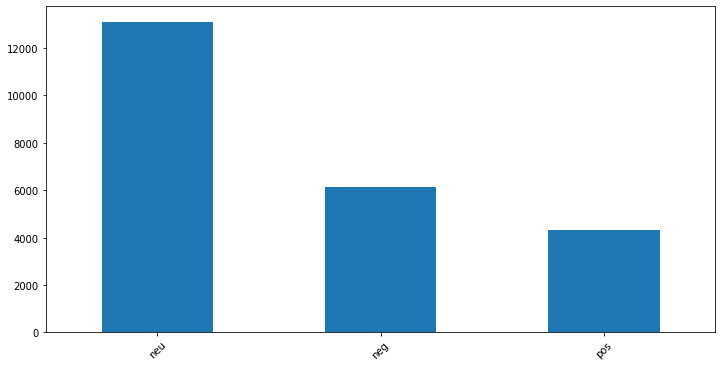

In [6]:
df['label'].value_counts().plot(kind='bar', figsize=(12, 6), rot=45)

## Process and Tokenize

In [7]:
def pre_tokenize(message):
    #     
    # Remove URL in string
    # 
    message = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', message)
    
    #     
    # Keep only thai letter and englist letter
    # 
    pattern = re.compile(r"[^\u0E00-\u0E7Fa-zA-Z' ]|^'|'$|''")
    char_to_remove = re.findall(pattern, message)
    message = "".join([char for char in message if not char in char_to_remove])
    
    return message

def post_tokenize(tokens):
    nt = []
    for tok in tokens:
        t = tok.strip()
        if t: 
            nt.append(t)
    return nt
        
def custom_tokenizer(message):
    message = pre_tokenize(message)
    tokens = word_tokenize(message)
    tokens = post_tokenize(tokens)
    return tokens



In [8]:
custom_tokenizer("ดอยสุเทพน้องง https://www.google.com ไปหมดแล้วววว #pm25")

['ดอย', 'สุเทพ', 'น้อง', 'ง', 'ไป', 'หมด', 'แล้ว', 'ววว', 'pm']

### Train Test Generate

In [9]:
train_df, test_df = train_test_split(df, test_size=0.15)
print('Train size: ', train_df.shape[0])
print('Test Size: ', test_df.shape[0])

Train size:  20013
Test Size:  3532


### Vectorizer

In [10]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000, token_pattern=None)
vectorizer.fit(df["message"])

CountVectorizer(max_features=3000, token_pattern=None,
                tokenizer=<function custom_tokenizer at 0x7f795d66d700>)

In [11]:
x_train = vectorizer.transform(train_df.message)
y_train = train_df.label

x_test = vectorizer.transform(test_df.message)
y_test = test_df.label

print('train x size: ', x_train.shape)
print('train y Size: ', y_train.shape)
print('-'*20)
print('test x size: ', x_test.shape)
print('test y Size: ', y_test.shape)

train x size:  (20013, 3000)
train y Size:  (20013,)
--------------------
test x size:  (3532, 3000)
test y Size:  (3532,)


### Train Model

In [12]:
est = RandomForestClassifier(n_jobs=8)
gs = GridSearchCV(est, 
                  param_grid={
                        'n_estimators': [100, 200, 300 ],
                        'max_depth': [100, 200, 500],
                    })
gs.fit(x_train, y_train, )

GridSearchCV(estimator=RandomForestClassifier(n_jobs=8),
             param_grid={'max_depth': [100, 200, 500],
                         'n_estimators': [100, 200, 300]})

In [13]:
print('best params', gs.best_params_)
print('best score: ', gs.best_score_)

best params {'max_depth': 200, 'n_estimators': 300}
best score:  0.7062408965389901


In [14]:
best_est = RandomForestClassifier(n_jobs=8, **gs.best_params_)
best_est.fit(x_train, y_train)

print(best_est.score(x_test, y_test))

0.7253680634201586


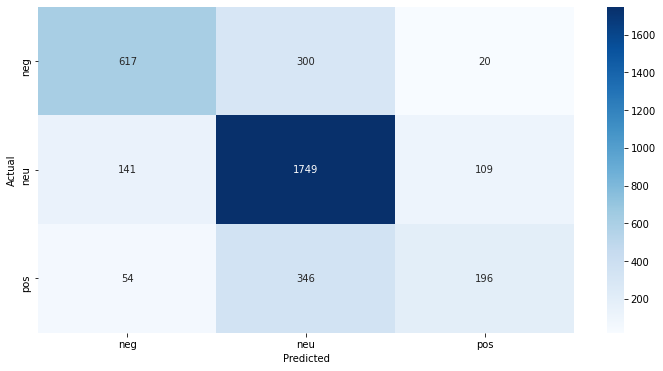

In [15]:
predict = best_est.predict(x_test)
conf_mat = confusion_matrix(y_test, predict)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(conf_mat, 
            ax=ax, 
            annot=True,
            cmap="Blues",
            fmt="d",
            xticklabels=best_est.classes_, 
            yticklabels=best_est.classes_,
        )
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Save model to file

In [16]:
dump(best_est, './out/sentiment.joblib')
dump(vectorizer, './out/sentiment_vect.joblib')

['./out/sentiment_vect.joblib']

## How to improve a model ?